In [1]:
# Внимание!!! Важно, что бы файлы с данными и исполняемый файл находились в одной папке, 
# тогда пути к тестовым и тренировочным наборам будут содержать только имена файлов.
# 
# В пути к тренировочным и тестовым данным запрежается использовать абсалютную адресацию, 
# то есть адресацию, в которой присутствуют имена папок. Путь должен содержать только имя файла.
#
# Напоминание: под моделью машинного обучения понимаются все действия с исходными данными, 
# которые необходимо произвести, что бы сопоставить признаки целевому значению.

### Область работы 1 (библиотеки)

In [2]:
# Данный блок в области 1 НЕ выполняется преподавателем
# 
# данный блок предназначен только для подключения необходимых библиотек
# запрещается подключать библиотеки в других блоках
#
# установка дополнительных библиотек размещается прямо здесь (обязательно закоментированы)
#
# pip install

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Enable experimental features
from sklearn.experimental import enable_iterative_imputer  # Это нужно до импорта IterativeImputer

# Preprocessing
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, TargetEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures, QuantileTransformer, PowerTransformer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# Column transformation
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV

# Models
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Metrics
from sklearn.metrics import mean_absolute_percentage_error, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, make_scorer

# Encoding (additional)
import category_encoders as ce

import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, PowerTransformer, QuantileTransformer, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from collections import OrderedDict

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingRegressor
cancer = load_breast_cancer()
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import classification_report, RocCurveDisplay, DetCurveDisplay,PrecisionRecallDisplay
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR


### Область работы 2 (поиск  модели .... )

In [2]:
# Данный блок(и) НЕ выполняются преподавателем в области 2
# блок(и) предназначены для поиска лучшей модели 
# должен быть понятен и очевиден отбор параметров модели
# 
# Запрещается размещать данные блоки за пределами обасти 2
# Все блоки данной области должны быть выполнены
#
# ЗАПРЕЩАЕТСЯ ИСПОЛЬЗОВАТЬ ТЕСТОВЫЙ НАБОР
#
# Путь к тренировочному набору
# 
path_train = 'train.csv'
path_test = 'test.csv'
df = pd.read_csv(path_train)
X_test = pd.read_csv(path_test)
print(df.shape, X_test.shape)

(380, 7) (164, 6)


# **Я выбрал 2 модели Lasso и Ridge (посмотрю, что с ними можно будет сделать)**

# **Lasso**

In [5]:
cat_features = ['Sex', 'Age']
num_features = ['BCS', 'Height', 'Girth', 'Length']
X = df.drop(columns=['Weight'], axis=1)
y = df['Weight']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
num_pipeline = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),  # Полиномиальные признаки
    ('scaler', StandardScaler())  # Стандартизация
])

# Пайплайн для категориальных признаков
cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Объединяем числовые и категориальные пайплайны в ColumnTransformer
CT = ColumnTransformer([
    ('num', num_pipeline, num_features),  # Числовые данные
    ('cat', cat_pipeline, cat_features)   # Категориальные данные
])

In [6]:
model = Pipeline(steps=[
    ('preprocessor', CT),
    ('regressor', Lasso())
])

In [7]:
param_grid = {
    # Степень полиномиальных признаков
    'preprocessor__num__poly__degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],

    # Параметр регуляризации alpha для Lasso
    'regressor__alpha': [0.01, 0.1, 1, 10, 50, 100, 500, 1000],

    # Нужно ли учитывать свободный член (fit_intercept)
    'regressor__fit_intercept': [True, False],

    # Максимальное количество итераций (для solver='saga' и 'lbfgs')
    'regressor__max_iter': [500, 1000, 5000],

    # Точность решения
    'regressor__tol': [1e-4, 1e-3, 1e-2]
}

# Инициализация GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,  # Кросс-валидация на 3 фолдах
    n_jobs=-1,  # Использовать все ядра
    verbose=1,
    scoring='neg_mean_squared_error'
)

# Обучение модели с помощью GridSearchCV
grid_search.fit(X_train, y_train)

# Вывод лучших параметров и оценки модели
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший результат на валидации (MSE):", -grid_search.best_score_)

# Оценка модели на тестовых данных
test_score = grid_search.score(X_test, y_test)
print("Результат на тестовых данных (MSE):", -test_score)

Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


/Volumes/MacMedia_MY/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.433e+03, tolerance: 1.303e+03
  model = cd_fast.enet_coordinate_descent(
/Volumes/MacMedia_MY/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.248e+03, tolerance: 1.360e+01
  model = cd_fast.enet_coordinate_descent(
/Volumes/MacMedia_MY/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

Лучшие параметры: {'preprocessor__num__poly__degree': 8, 'regressor__alpha': 0.1, 'regressor__fit_intercept': True, 'regressor__max_iter': 500, 'regressor__tol': 0.0001}
Лучший результат на валидации (MSE): 69.88620663916161
Результат на тестовых данных (MSE): 58.25620070306644


# **Ridge**

In [8]:
cat_features = ['Sex', 'Age']
num_features = ['BCS', 'Height', 'Girth', 'Length']

In [9]:
X = df.drop(columns = ['Weight'], axis=1)
y = df['Weight']

In [10]:
num_pipeline = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),  # Полиномиальные признаки
    ('scaler', StandardScaler()),  # Стандартизация
])

# Пайплайн для категориальных признаков
cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Объединяем числовые и категориальные пайплайны в ColumnTransformer
CT = ColumnTransformer([
    ('num', num_pipeline, num_features),  # Числовые данные
    ('cat', cat_pipeline, cat_features)   # Категориальные данные
])


In [11]:
model = Pipeline(steps=[
    ('preprocessor', CT),
    ('regressor', Ridge())
])

In [12]:
param_grid = {
    # Полиномиальные признаки (степени от 1 до 10 для полных переборов)
    'preprocessor__num__poly__degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  # Степень полиномиальных признаков

    # Регуляризация (параметр alpha в Ridge)
    'regressor__alpha': [0.01, 0.1, 1, 10, 50, 100, 500, 1000],  # Разнообразие значений alpha

    # Метод решения задачи для Ridge
    'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga', 'lbfgs'],  # Дополнительно добавлен 'lbfgs'

    # Нужно ли учитывать свободный член
    'regressor__fit_intercept': [True, False],  # Разные варианты с учетом и без учета

    # Дополнительные параметры для регуляризации и решения задачи
    'regressor__max_iter': [500, 1000, 5000],  # Максимальное количество итераций (для solver='saga' и 'lbfgs')
    'regressor__tol': [1e-4, 1e-3, 1e-2],  # Точность решения
}

# Инициализация GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,  # Кросс-валидация на 3 фолдах
    n_jobs=-1,  # Использовать все ядра
    verbose=1,
    scoring='neg_mean_squared_error'
)

# Обучение модели с помощью GridSearchCV
grid_search.fit(X_train, y_train)

# Вывод лучших параметров и оценки модели
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший результат на валидации (MSE):", -grid_search.best_score_)

# Оценка модели на тестовых данных
test_score = grid_search.score(X_test, y_test)
print("Результат на тестовых данных (MSE):", -test_score)

Fitting 3 folds for each of 8640 candidates, totalling 25920 fits


/Volumes/MacMedia_MY/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Volumes/MacMedia_MY/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Volumes/MacMedia_MY/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Volumes/MacMedia_MY/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Volumes/MacMedia_MY/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Лучшие параметры: {'preprocessor__num__poly__degree': 3, 'regressor__alpha': 10, 'regressor__fit_intercept': True, 'regressor__max_iter': 500, 'regressor__solver': 'lsqr', 'regressor__tol': 0.0001}
Лучший результат на валидации (MSE): 71.08778699712137
Результат на тестовых данных (MSE): 55.919300355084665


# **Посмотрим как изменится MSE если фигакним новые фичи**

# **Lasso** + фича 

In [7]:
df['Body_Proportion'] = df['Girth'] / df['Height']

In [8]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso

# Определение признаков
cat_features = ['Sex', 'Age']
num_features = ['BCS', 'Height', 'Girth', 'Length']
X = df.drop(columns=['Weight'], axis=1)
y = df['Weight']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Пайплайн для числовых признаков
num_pipeline = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),  # Полиномиальные признаки
    ('scaler', StandardScaler())  # Стандартизация
])

# Пайплайн для категориальных признаков
cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Объединение пайплайнов для числовых и категориальных признаков в ColumnTransformer
CT = ColumnTransformer([
    ('num', num_pipeline, num_features),  # Числовые данные
    ('cat', cat_pipeline, cat_features)   # Категориальные данные
])

# Полный пайплайн с регрессором
model = Pipeline(steps=[
    ('preprocessor', CT),
    ('regressor', Lasso())
])

# Параметры для GridSearchCV
param_grid = {
    # Степень полиномиальных признаков
    'preprocessor__num__poly__degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],

    # Параметр регуляризации alpha для Lasso
    'regressor__alpha': [0.01, 0.1, 1, 10, 50, 100, 500, 1000],

    # Нужно ли учитывать свободный член (fit_intercept)
    'regressor__fit_intercept': [True, False],

    # Максимальное количество итераций (для solver='saga' и 'lbfgs')
    'regressor__max_iter': [500, 1000, 5000],

    # Точность решения
    'regressor__tol': [1e-4, 1e-3, 1e-2]
}

# Инициализация GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,  # Кросс-валидация на 3 фолдах
    n_jobs=-1,  # Использовать все ядра
    verbose=1,
    scoring='neg_mean_squared_error'  # Отрицательное значение MSE
)

# Обучение модели с помощью GridSearchCV
grid_search.fit(X_train, y_train)

# Вывод лучших параметров и оценки модели на валидации
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший результат на валидации (MSE):", -grid_search.best_score_)

# Прогнозирование на тестовых данных
y_pred = grid_search.predict(X_test)

# Вычисление MSE на тестовых данных
mse_test = mean_squared_error(y_test, y_pred)
print("MSE на тестовых данных:", mse_test)


Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


/Volumes/MacMedia_MY/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.580e+03, tolerance: 1.357e+01
  model = cd_fast.enet_coordinate_descent(
/Volumes/MacMedia_MY/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.168e+03, tolerance: 1.527e+01
  model = cd_fast.enet_coordinate_descent(
/Volumes/MacMedia_MY/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

Лучшие параметры: {'preprocessor__num__poly__degree': 5, 'regressor__alpha': 0.1, 'regressor__fit_intercept': True, 'regressor__max_iter': 500, 'regressor__tol': 0.001}
Лучший результат на валидации (MSE): 66.13939965613001
MSE на тестовых данных: 64.16060097262239


# **Ridge** (c фичой)

In [10]:
cat_features = ['Sex', 'Age']
num_features = ['BCS', 'Height', 'Girth', 'Length']
X = df.drop(columns = ['Weight'], axis=1)
y = df['Weight']
num_pipeline = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),  # Полиномиальные признаки
    ('scaler', StandardScaler()),  # Стандартизация
])

# Пайплайн для категориальных признаков
cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Объединяем числовые и категориальные пайплайны в ColumnTransformer
CT = ColumnTransformer([
    ('num', num_pipeline, num_features),  # Числовые данные
    ('cat', cat_pipeline, cat_features)   # Категориальные данные
])
model = Pipeline(steps=[
    ('preprocessor', CT),
    ('regressor', Ridge())
])

from sklearn.metrics import mean_squared_error

param_grid = {
    # Полиномиальные признаки (степени от 1 до 10 для полных переборов)
    'preprocessor__num__poly__degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  # Степень полиномиальных признаков

    # Регуляризация (параметр alpha в Ridge)
    'regressor__alpha': [0.01, 0.1, 1, 10, 50, 100, 500, 1000],  # Разнообразие значений alpha

    # Метод решения задачи для Ridge
    'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga', 'lbfgs'],  # Дополнительно добавлен 'lbfgs'

    # Нужно ли учитывать свободный член
    'regressor__fit_intercept': [True, False],  # Разные варианты с учетом и без учета

    # Дополнительные параметры для регуляризации и решения задачи
    'regressor__max_iter': [500, 1000, 5000],  # Максимальное количество итераций (для solver='saga' и 'lbfgs')
    'regressor__tol': [1e-4, 1e-3, 1e-2],  # Точность решения
}

# Инициализация GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,  # Кросс-валидация на 3 фолдах
    n_jobs=-1,  # Использовать все ядра
    verbose=1,
    scoring='neg_mean_squared_error'  # Используем отрицательный MSE
)

# Обучение модели с помощью GridSearchCV
grid_search.fit(X_train, y_train)

# Вывод лучших параметров и оценки модели
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший результат на валидации (MSE):", -grid_search.best_score_)  # Отрицательное значение для MSE

# Прогнозирование на тестовых данных
y_pred = grid_search.predict(X_test)

# Вычисление MSE на тестовых данных
mse_test = mean_squared_error(y_test, y_pred)
print("MSE на тестовых данных:", mse_test)


Fitting 3 folds for each of 8640 candidates, totalling 25920 fits


/Volumes/MacMedia_MY/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Volumes/MacMedia_MY/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Volumes/MacMedia_MY/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Volumes/MacMedia_MY/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Volumes/MacMedia_MY/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Лучшие параметры: {'preprocessor__num__poly__degree': 2, 'regressor__alpha': 0.01, 'regressor__fit_intercept': True, 'regressor__max_iter': 500, 'regressor__solver': 'lsqr', 'regressor__tol': 0.001}
Лучший результат на валидации (MSE): 64.51880436993082
MSE на тестовых данных: 67.23899162187925


# **Чек SVR**

In [14]:
cat_features = ['Sex', 'Age']
num_features = ['BCS', 'Height', 'Girth', 'Length']
X = df.drop(columns = ['Weight'], axis=1)
y = df['Weight']
num_pipeline = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),  # Полиномиальные признаки
    ('scaler', StandardScaler())  # Стандартизация
])

# Объявляем категориальный пайплайн
cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Объединяем числовой и категориальный пайплайны
CT = ColumnTransformer([
    ('num', num_pipeline, num_features),  # Числовые данные
    ('cat', cat_pipeline, cat_features)   # Категориальные данные
])
model = Pipeline(steps=[
    ('preprocessor', CT),
    ('regressor', SVR())
])
from sklearn.metrics import mean_squared_error

param_grid = {
    'preprocessor__num__poly__degree': [1, 2, 3, 4, 5],  # Степень полиномиальных признаков
    'regressor__C': [0.1, 1, 10, 100, 1000],  # Регуляризация
    'regressor__kernel': ['linear', 'poly', 'rbf'],  # Тип ядра
    'regressor__epsilon': [0.01, 0.1, 0.2],  # Параметр для регрессии
}

# Инициализация GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,  # Кросс-валидация на 3 фолдах
    n_jobs=-1,  # Использовать все ядра
    verbose=1,
    scoring='neg_mean_squared_error'  # Используем MSE для оценки
)

# Обучение модели с помощью GridSearchCV
grid_search.fit(X_train, y_train)

# Вывод лучших параметров и оценки модели
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший результат на валидации (MSE):", -grid_search.best_score_)

# Прогноз на тестовых данных
y_pred = grid_search.predict(X_test)

# Вычисление MSE на тестовых данных
mse_test = mean_squared_error(y_test, y_pred)

# Вывод MSE для тестовых данных
print("MSE на тестовых данных:", mse_test)


Fitting 3 folds for each of 225 candidates, totalling 675 fits
Лучшие параметры: {'preprocessor__num__poly__degree': 5, 'regressor__C': 1, 'regressor__epsilon': 0.2, 'regressor__kernel': 'linear'}
Лучший результат на валидации (MSE): 72.94605190306102
MSE на тестовых данных: 58.54561869524719


# **Войтинг** 

MSE for Lasso: 56.9542
MSE for SVR: 57.7934
MSE for Ridge: 56.1785
MSE for VotingRegressor: 55.9501


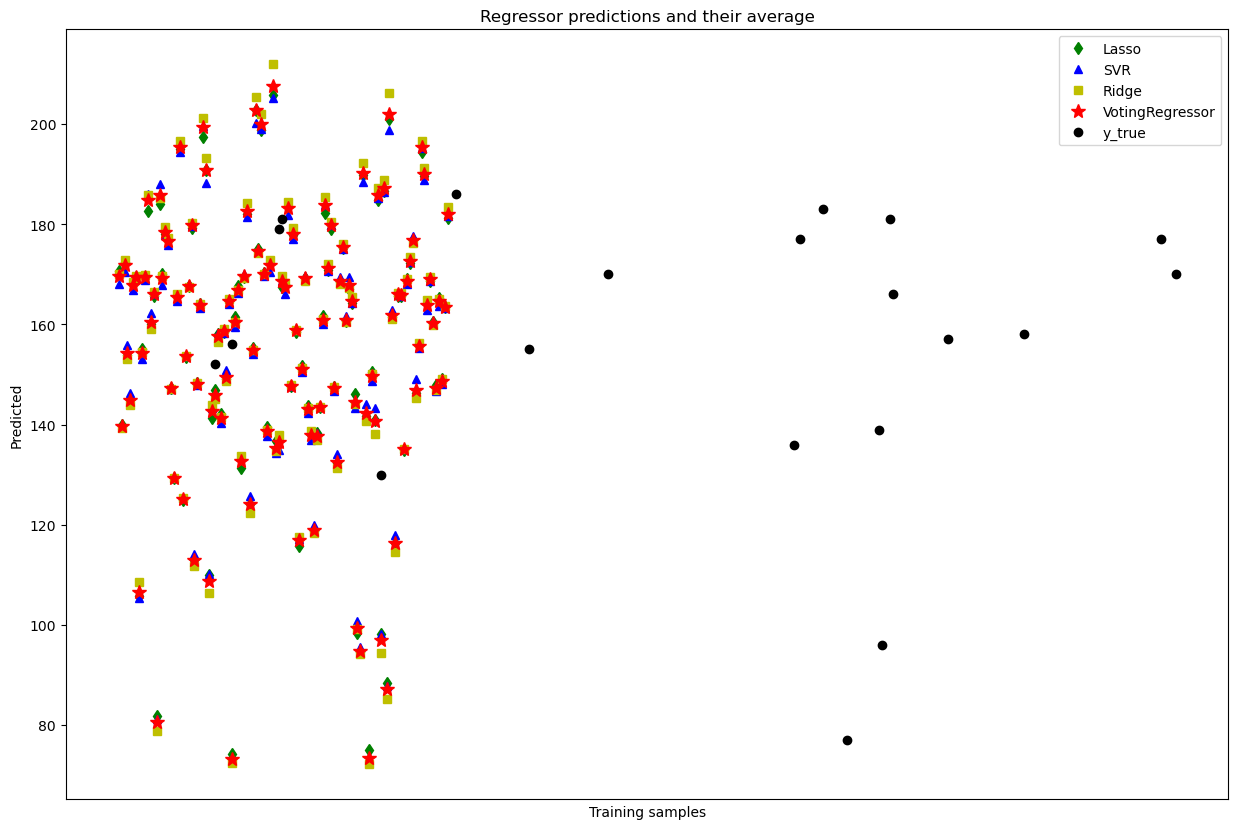

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder

# Предполагается, что df - это ваш DataFrame с признаками
cat_features = ['Sex', 'Age']
num_features = ['BCS', 'Height', 'Girth', 'Length']
X = df.drop(columns = ['Weight'], axis=1)
y = df['Weight']

# Пайплайн для числовых признаков
num_pipeline = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),  # Полиномиальные признаки
    ('scaler', StandardScaler())  # Стандартизация
])

# Пайплайн для категориальных признаков
cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Объединяем числовые и категориальные пайплайны в ColumnTransformer
CT = ColumnTransformer([
    ('num', num_pipeline, num_features),  # Числовые данные
    ('cat', cat_pipeline, cat_features)   # Категориальные данные
])

# Разделение данных на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Инициализация моделей
# lasso = Pipeline(steps=[('preprocessor', CT), ('regressor', Lasso(alpha=0.1))])
# svr = Pipeline(steps=[('preprocessor', CT), ('regressor', SVR(kernel='rbf', C=1, epsilon=0.1))])
# ridge = Pipeline(steps=[('preprocessor', CT), ('regressor', Ridge(alpha=1.0))])

# lasso = Pipeline(steps=[('preprocessor', CT), ('regressor', Lasso(alpha=0.1), {'preprocessor__num__poly__degree': 5, 'regressor__alpha': 0.1, 'regressor__fit_intercept': True, 'regressor__max_iter': 500, 'regressor__tol': 0.001})])
# svr = Pipeline(steps=[('preprocessor', CT), ('regressor', SVR(kernel='rbf', C=1, epsilon=0.1)), preprocessor__num__poly__degree': 5, 'regressor__C': 1, 'regressor__epsilon': 0.2, 'regressor__kernel': 'linear'])
# ridge = Pipeline(steps=[('preprocessor', CT), ('regressor', Ridge(alpha=1.0))'preprocessor__num__poly__degree': 2, 'regressor__alpha': 0.01, 'regressor__fit_intercept': True, 'regressor__max_iter': 500, 'regressor__solver': 'lsqr', 'regressor__tol': 0.001} Для Lasso])

lasso = Pipeline(steps=[
    ('preprocessor', CT),
    ('regressor', Lasso(alpha=0.1, fit_intercept=True, max_iter=500, tol=0.001))
])

# Пайплайн для SVR с переданными параметрами
svr = Pipeline(steps=[
    ('preprocessor', CT),
    ('regressor', SVR(kernel='linear', C=1, epsilon=0.2))
])

# Пайплайн для Ridge с переданными параметрами
ridge = Pipeline(steps=[
    ('preprocessor', CT),
    ('regressor', Ridge(alpha=0.01, fit_intercept=True, max_iter=500, solver='lsqr', tol=0.001))
])


# Обучение моделей
lasso.fit(X_train, y_train)
svr.fit(X_train, y_train)
ridge.fit(X_train, y_train)

# Объединение моделей в VotingRegressor
voting_reg = VotingRegressor([("lasso", lasso), ("svr", svr), ("ridge", ridge)])

# Обучение VotingRegressor
voting_reg.fit(X_train, y_train)

# Прогнозы на тестовых данных
lasso_pred = lasso.predict(X_test)
svr_pred = svr.predict(X_test)
ridge_pred = ridge.predict(X_test)
voting_pred = voting_reg.predict(X_test)

# Вычисление MSE для каждой модели
lasso_mse = mean_squared_error(y_test, lasso_pred)
svr_mse = mean_squared_error(y_test, svr_pred)
ridge_mse = mean_squared_error(y_test, ridge_pred)
voting_mse = mean_squared_error(y_test, voting_pred)

# Вывод MSE для каждой модели
print(f"MSE for Lasso: {lasso_mse:.4f}")
print(f"MSE for SVR: {svr_mse:.4f}")
print(f"MSE for Ridge: {ridge_mse:.4f}")
print(f"MSE for VotingRegressor: {voting_mse:.4f}")

# Визуализация
plt.figure(figsize=(15, 10))
plt.plot(lasso_pred, "gd", label="Lasso")
plt.plot(svr_pred, "b^", label="SVR")
plt.plot(ridge_pred, "ys", label="Ridge")
plt.plot(voting_pred, "r*", ms=10, label="VotingRegressor")
plt.plot(y_test[:20], "ko", label="y_true")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("Predicted")
plt.xlabel("Training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")

plt.show()


# **Жесткое голосование**

MSE for Lasso: 56.9542
MSE for SVR: 57.7934
MSE for Ridge: 56.1785
MSE for VotingRegressor: 55.9501


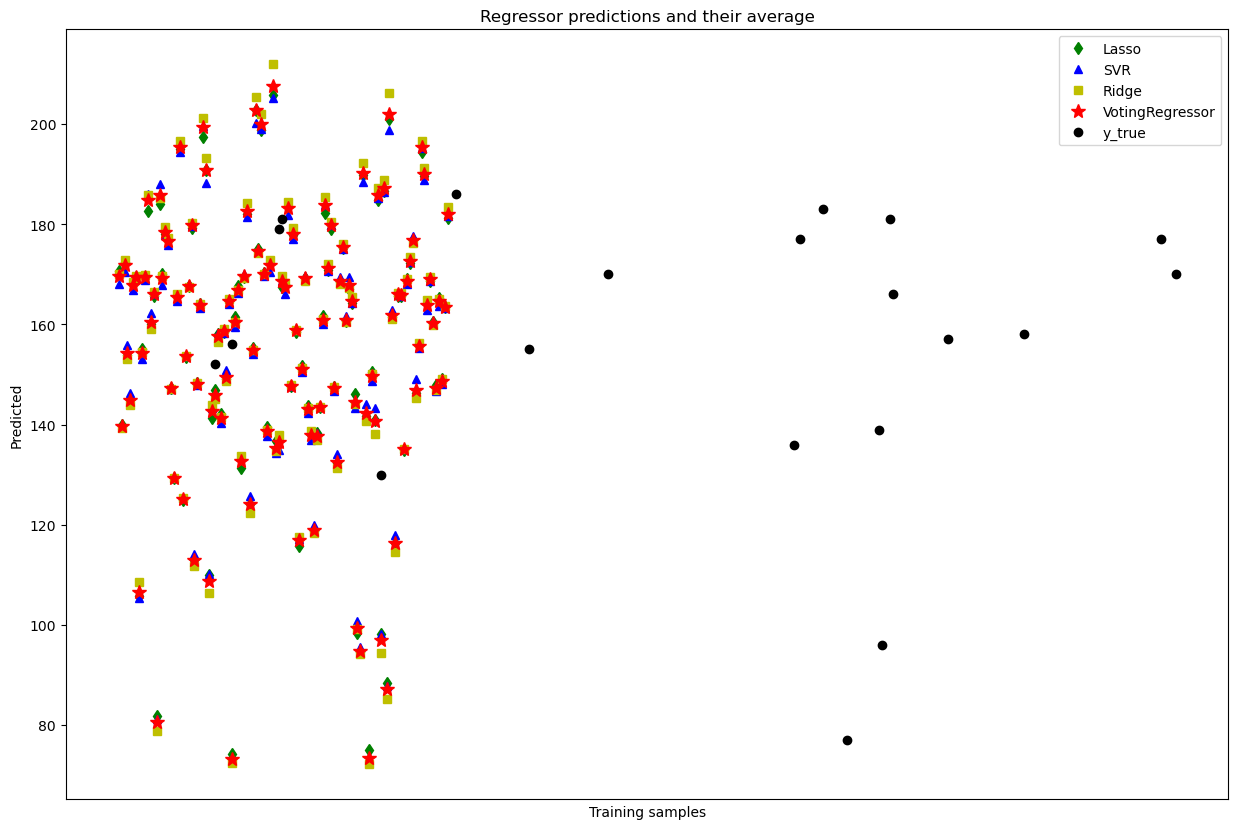

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder

# Предполагается, что df - это ваш DataFrame с признаками
cat_features = ['Sex', 'Age']
num_features = ['BCS', 'Height', 'Girth', 'Length']
X = df.drop(columns = ['Weight'], axis=1)
y = df['Weight']

# Пайплайн для числовых признаков
num_pipeline = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),  # Полиномиальные признаки
    ('scaler', StandardScaler())  # Стандартизация
])

# Пайплайн для категориальных признаков
cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Объединяем числовые и категориальные пайплайны в ColumnTransformer
CT = ColumnTransformer([
    ('num', num_pipeline, num_features),  # Числовые данные
    ('cat', cat_pipeline, cat_features)   # Категориальные данные
])

# Разделение данных на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Инициализация моделей с параметрами
lasso = Pipeline(steps=[
    ('preprocessor', CT),
    ('regressor', Lasso(alpha=0.1, fit_intercept=True, max_iter=500, tol=0.001))
])

svr = Pipeline(steps=[
    ('preprocessor', CT),
    ('regressor', SVR(kernel='linear', C=1, epsilon=0.2))
])

ridge = Pipeline(steps=[
    ('preprocessor', CT),
    ('regressor', Ridge(alpha=0.01, fit_intercept=True, max_iter=500, solver='lsqr', tol=0.001))
])

# Обучение моделей
lasso.fit(X_train, y_train)
svr.fit(X_train, y_train)
ridge.fit(X_train, y_train)

# Объединение моделей в VotingRegressor
voting_reg = VotingRegressor([("lasso", lasso), ("svr", svr), ("ridge", ridge)])

# Обучение VotingRegressor
voting_reg.fit(X_train, y_train)

# Прогнозы на тестовых данных
lasso_pred = lasso.predict(X_test)
svr_pred = svr.predict(X_test)
ridge_pred = ridge.predict(X_test)
voting_pred = voting_reg.predict(X_test)

# Вычисление MSE для каждой модели
lasso_mse = mean_squared_error(y_test, lasso_pred)
svr_mse = mean_squared_error(y_test, svr_pred)
ridge_mse = mean_squared_error(y_test, ridge_pred)
voting_mse = mean_squared_error(y_test, voting_pred)

# Вывод MSE для каждой модели
print(f"MSE for Lasso: {lasso_mse:.4f}")
print(f"MSE for SVR: {svr_mse:.4f}")
print(f"MSE for Ridge: {ridge_mse:.4f}")
print(f"MSE for VotingRegressor: {voting_mse:.4f}")

# Визуализация
plt.figure(figsize=(15, 10))
plt.plot(lasso_pred, "gd", label="Lasso")
plt.plot(svr_pred, "b^", label="SVR")
plt.plot(ridge_pred, "ys", label="Ridge")
plt.plot(voting_pred, "r*", ms=10, label="VotingRegressor")
plt.plot(y_test[:20], "ko", label="y_true")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("Predicted")
plt.xlabel("Training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")

plt.show()


# **Стекинг**

MSE for StackingRegressor: 56.1445


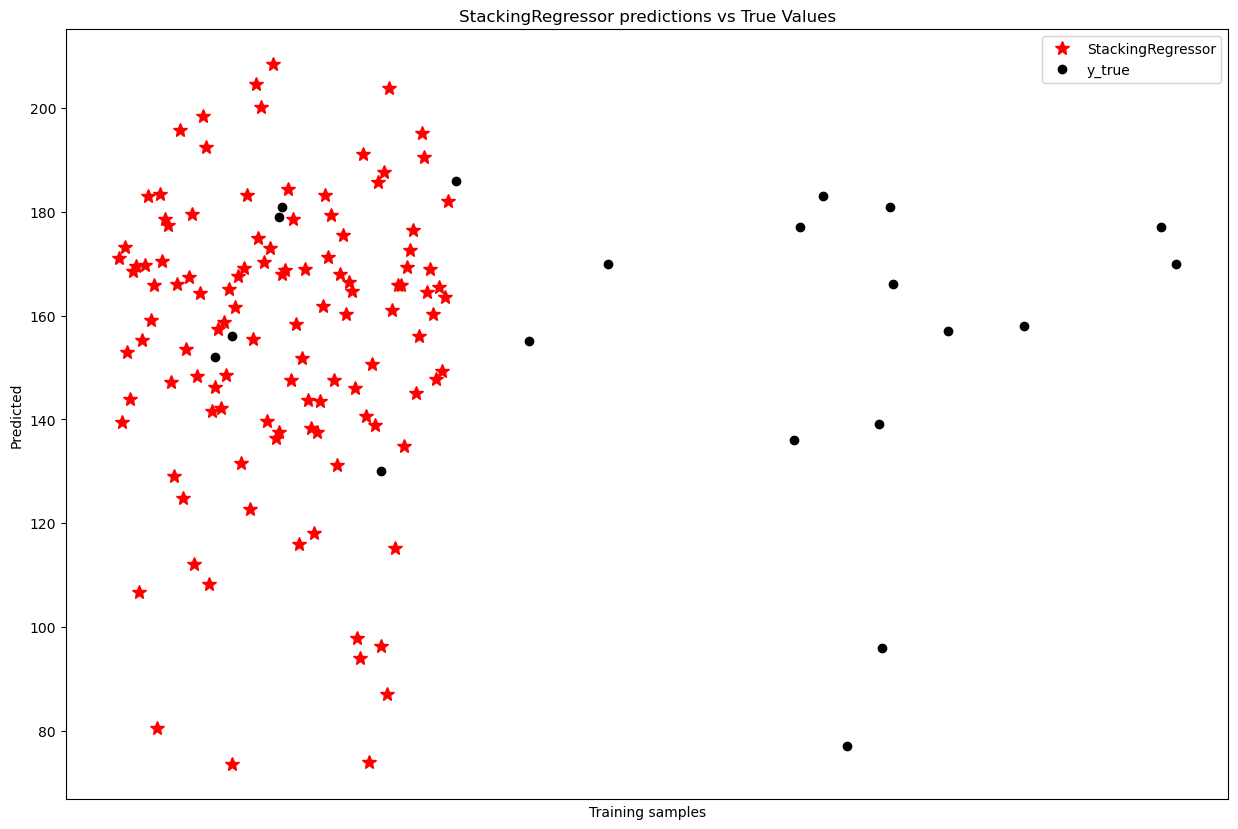

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder

# Предполагается, что df - это ваш DataFrame с признаками
cat_features = ['Sex', 'Age']
num_features = ['BCS', 'Height', 'Girth', 'Length']
X = df.drop(columns = ['Weight'], axis=1)
y = df['Weight']

# Пайплайн для числовых признаков
num_pipeline = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),  # Полиномиальные признаки
    ('scaler', StandardScaler())  # Стандартизация
])

# Пайплайн для категориальных признаков
cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Объединяем числовые и категориальные пайплайны в ColumnTransformer
CT = ColumnTransformer([
    ('num', num_pipeline, num_features),  # Числовые данные
    ('cat', cat_pipeline, cat_features)   # Категориальные данные
])

# Разделение данных на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Инициализация моделей
lasso = Pipeline(steps=[
    ('preprocessor', CT),
    ('regressor', Lasso(alpha=0.1, fit_intercept=True, max_iter=500, tol=0.001))
])

svr = Pipeline(steps=[
    ('preprocessor', CT),
    ('regressor', SVR(kernel='linear', C=1, epsilon=0.2))
])

ridge = Pipeline(steps=[
    ('preprocessor', CT),
    ('regressor', Ridge(alpha=0.01, fit_intercept=True, max_iter=500, solver='lsqr', tol=0.001))
])

# Финальный регрессор
final_regressor = LinearRegression()

# Создание StackingRegressor
stacking_regressor = StackingRegressor(
    estimators=[('lasso', lasso), ('svr', svr), ('ridge', ridge)],
    final_estimator=final_regressor
)

# Обучение StackingRegressor
stacking_regressor.fit(X_train, y_train)

# Прогнозы на тестовых данных
stacking_pred = stacking_regressor.predict(X_test)

# Вычисление MSE для StackingRegressor
stacking_mse = mean_squared_error(y_test, stacking_pred)

# Вывод MSE для StackingRegressor
print(f"MSE for StackingRegressor: {stacking_mse:.4f}")

# Визуализация
plt.figure(figsize=(15, 10))
plt.plot(stacking_pred, "r*", ms=10, label="StackingRegressor")
plt.plot(y_test[:20], "ko", label="y_true")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("Predicted")
plt.xlabel("Training samples")
plt.legend(loc="best")
plt.title("StackingRegressor predictions vs True Values")

plt.show()


# **Шаманство с предобработкой** (все стало хуже) 

In [26]:
# Предполагаем, что df - это ваш DataFrame с признаками
cat_features = ['Sex', 'Age']
num_features = ['BCS', 'Height', 'Girth', 'Length']
X = df.drop(columns = ['Weight'], axis=1)
y = df['Weight']

# Пайплайн для числовых признаков
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Импьютер для числовых признаков
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),  # Полиномиальные признаки
    ('scaler', StandardScaler()),  # Стандартизация
    ('binner', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'))  # Бининг
])

# Пайплайн для категориальных признаков
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Импьютер для категориальных признаков
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))  # OneHotEncoder
])

# Объединяем числовые и категориальные пайплайны в ColumnTransformer
CT = ColumnTransformer([
    ('num', num_pipeline, num_features),  # Числовые данные
    ('cat', cat_pipeline, cat_features)   # Категориальные данные
])

MSE for Lasso: 88.9369
MSE for SVR: 93.6807
MSE for Ridge: 89.1722
MSE for VotingRegressor: 89.4910


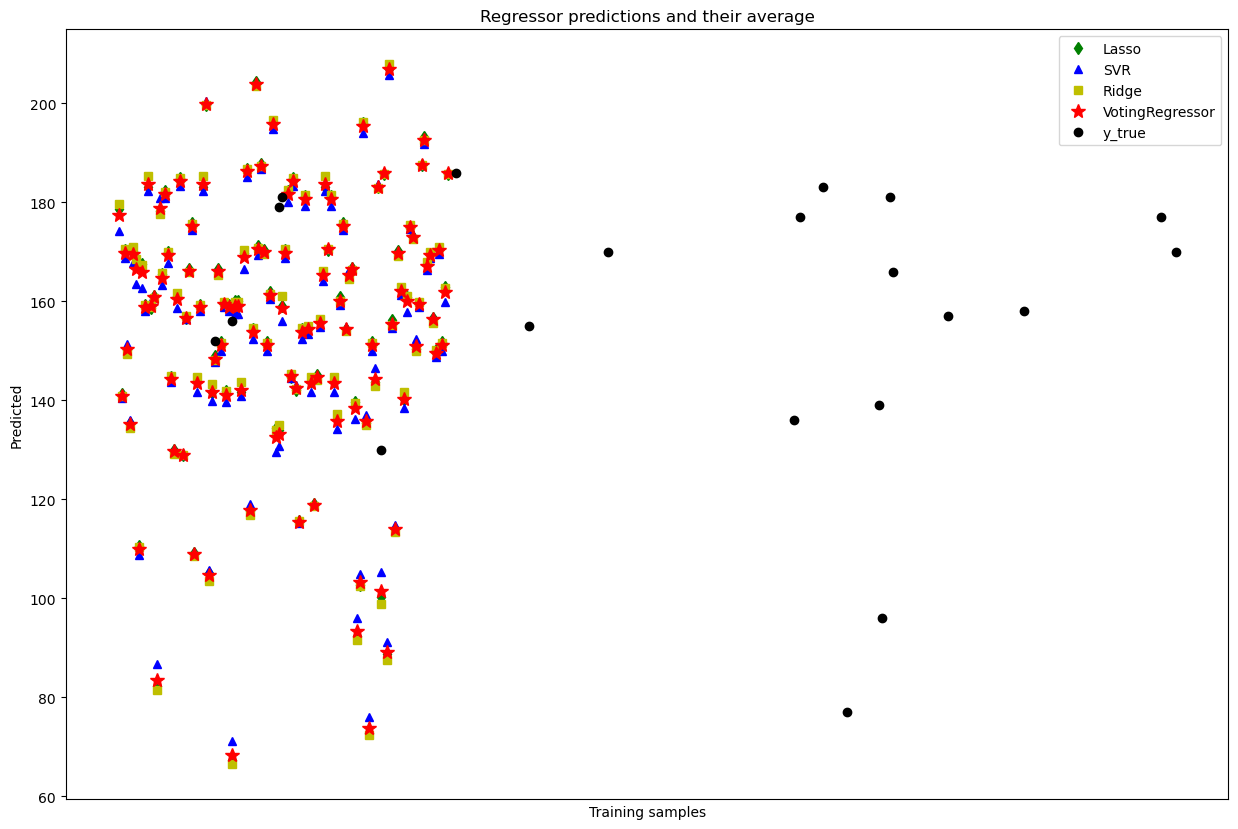

In [27]:
# Разделение данных на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Инициализация моделей с параметрами
lasso = Pipeline(steps=[
    ('preprocessor', CT),
    ('regressor', Lasso(alpha=0.1, fit_intercept=True, max_iter=500, tol=0.001))
])

svr = Pipeline(steps=[
    ('preprocessor', CT),
    ('regressor', SVR(kernel='linear', C=1, epsilon=0.2))
])

ridge = Pipeline(steps=[
    ('preprocessor', CT),
    ('regressor', Ridge(alpha=0.01, fit_intercept=True, max_iter=500, solver='lsqr', tol=0.001))
])

# Обучение моделей
lasso.fit(X_train, y_train)
svr.fit(X_train, y_train)
ridge.fit(X_train, y_train)

# Объединение моделей в VotingRegressor
voting_reg = VotingRegressor([("lasso", lasso), ("svr", svr), ("ridge", ridge)])

# Обучение VotingRegressor
voting_reg.fit(X_train, y_train)

# Прогнозы на тестовых данных
lasso_pred = lasso.predict(X_test)
svr_pred = svr.predict(X_test)
ridge_pred = ridge.predict(X_test)
voting_pred = voting_reg.predict(X_test)

# Вычисление MSE для каждой модели
lasso_mse = mean_squared_error(y_test, lasso_pred)
svr_mse = mean_squared_error(y_test, svr_pred)
ridge_mse = mean_squared_error(y_test, ridge_pred)
voting_mse = mean_squared_error(y_test, voting_pred)

# Вывод MSE для каждой модели
print(f"MSE for Lasso: {lasso_mse:.4f}")
print(f"MSE for SVR: {svr_mse:.4f}")
print(f"MSE for Ridge: {ridge_mse:.4f}")
print(f"MSE for VotingRegressor: {voting_mse:.4f}")

# Визуализация
plt.figure(figsize=(15, 10))
plt.plot(lasso_pred, "gd", label="Lasso")
plt.plot(svr_pred, "b^", label="SVR")
plt.plot(ridge_pred, "ys", label="Ridge")
plt.plot(voting_pred, "r*", ms=10, label="VotingRegressor")
plt.plot(y_test[:20], "ko", label="y_true")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("Predicted")
plt.xlabel("Training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")

plt.show()

# **Войтинг с шаманством с новым столбиком**

MSE for Lasso: 1.4887
MSE for SVR: 1.1742
MSE for Ridge: 0.2210
MSE for VotingRegressor: 0.6405


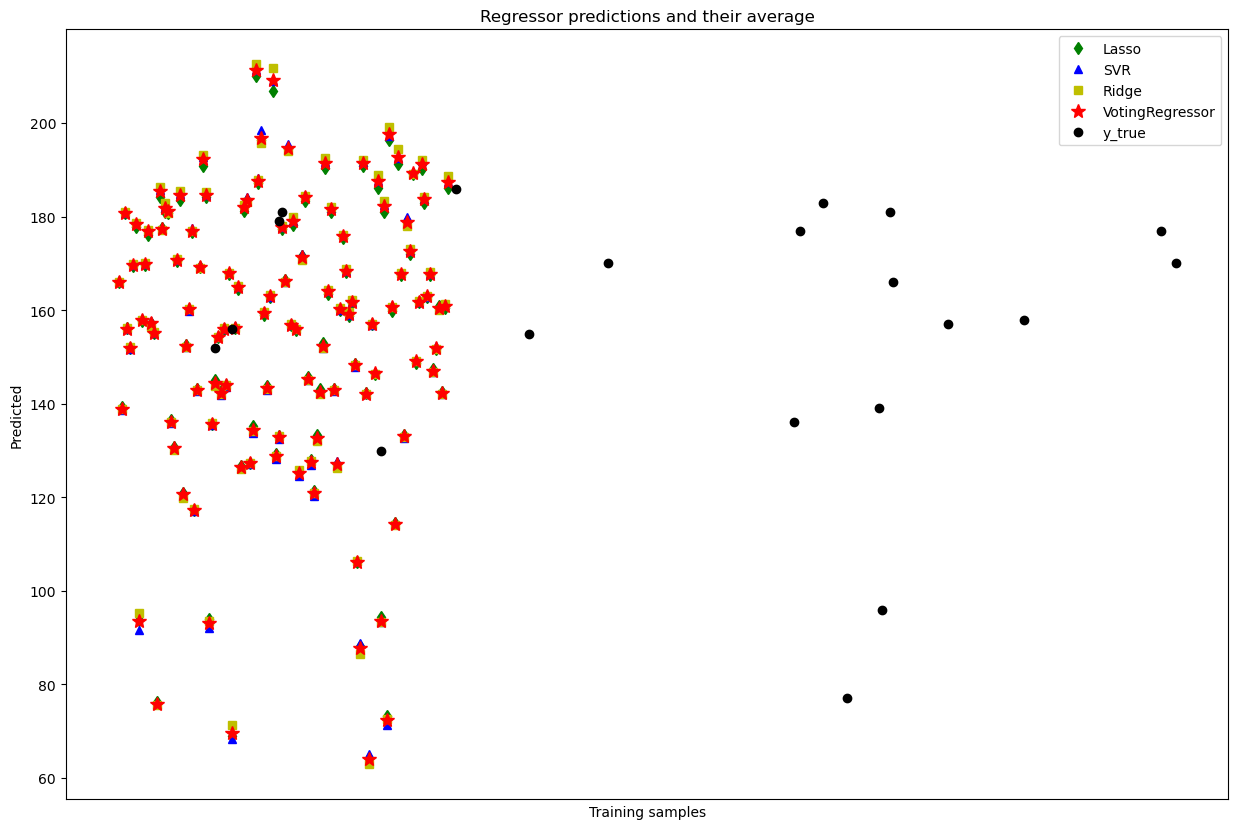

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder

# Пример DataFrame с признаками
# Предполагается, что df - это ваш DataFrame с признаками

df['Body_Proportion'] = df['Girth'] / df['Height']
df['BMI'] = df['Weight'] / (df['Height'] ** 2)  # Используем ** вместо ^ для возведения в степень
cat_features = ['Sex', 'Age']
num_features = ['BCS', 'Height', 'Girth', 'Length', 'Body_Proportion', 'BMI']


X = df.drop(columns=['Weight'], axis=1)
y = df['Weight']

# Пайплайн для числовых признаков
num_pipeline = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),  # Полиномиальные признаки
    ('scaler', StandardScaler())  # Стандартизация
])

# Пайплайн для категориальных признаков
cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Объединяем числовые и категориальные пайплайны в ColumnTransformer
CT = ColumnTransformer([
    ('num', num_pipeline, num_features),  # Числовые данные
    ('cat', cat_pipeline, cat_features)   # Категориальные данные
])

# Разделение данных на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Инициализация моделей
lasso = Pipeline(steps=[
    ('preprocessor', CT),
    ('regressor', Lasso(alpha=0.1, fit_intercept=True, max_iter=500, tol=0.001))
])

# Пайплайн для SVR с переданными параметрами
svr = Pipeline(steps=[
    ('preprocessor', CT),
    ('regressor', SVR(kernel='linear', C=1, epsilon=0.2))
])

# Пайплайн для Ridge с переданными параметрами
ridge = Pipeline(steps=[
    ('preprocessor', CT),
    ('regressor', Ridge(alpha=0.01, fit_intercept=True, max_iter=500, solver='lsqr', tol=0.001))
])

# Обучение моделей
lasso.fit(X_train, y_train)
svr.fit(X_train, y_train)
ridge.fit(X_train, y_train)

# Объединение моделей в VotingRegressor
voting_reg = VotingRegressor([("lasso", lasso), ("svr", svr), ("ridge", ridge)])

# Обучение VotingRegressor
voting_reg.fit(X_train, y_train)

# Прогнозы на тестовых данных
lasso_pred = lasso.predict(X_test)
svr_pred = svr.predict(X_test)
ridge_pred = ridge.predict(X_test)
voting_pred = voting_reg.predict(X_test)

# Вычисление MSE для каждой модели
lasso_mse = mean_squared_error(y_test, lasso_pred)
svr_mse = mean_squared_error(y_test, svr_pred)
ridge_mse = mean_squared_error(y_test, ridge_pred)
voting_mse = mean_squared_error(y_test, voting_pred)

# Вывод MSE для каждой модели
print(f"MSE for Lasso: {lasso_mse:.4f}")
print(f"MSE for SVR: {svr_mse:.4f}")
print(f"MSE for Ridge: {ridge_mse:.4f}")
print(f"MSE for VotingRegressor: {voting_mse:.4f}")

# Визуализация
plt.figure(figsize=(15, 10))
plt.plot(lasso_pred, "gd", label="Lasso")
plt.plot(svr_pred, "b^", label="SVR")
plt.plot(ridge_pred, "ys", label="Ridge")
plt.plot(voting_pred, "r*", ms=10, label="VotingRegressor")
plt.plot(y_test[:20], "ko", label="y_true")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("Predicted")
plt.xlabel("Training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")

plt.show()